# Generative modelling in deep learning

*This notebook consists of common introductory questions, followed by 4 different generative models, and a common conclusive question. **Choose & implement 2 among the 4 models**, not all of them! If you train more models, write down below the 2 ones you want to be graded on. Do not forget the last common question.*

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> Given the generative modelling task considered, we need to use relevant metrics in order to compare the generated data distribution with the original data distribution. The most common metrics used for this purpose are:
> - **KL divergence**: The Kullback-Leibler divergence writes as: 
> \begin{equation*} D_{KL}(p_D||p_\theta) = \mathbb{E}_{x \sim p_D}\left[\log \frac{p_D(x)}{p_\theta(x)}\right] = \int p_D(x) \log \frac{p_D(x)}{p_\theta(x)} dx \end{equation*}. 
> It is not symmetric and is not a true distance metric, but it is a positive definite form (non-negative and is zero if and only if the two distributions are the same). 
> - **Jensen-Shannon divergence**: The Jensen-Shannon divergence is a symmetric and smoothed version of the KL divergence. It writes as:
> \begin{equation*} D_{JS}(p_D||p_\theta) = \frac{1}{2} D_{KL}\left(p_D \mid \mid \frac{p_D+p_\theta}{2}\right) + \frac{1}{2} D_{KL}\left(p_\theta \mid \mid \frac{p_D+p_\theta}{2}\right) \end{equation*}.
> - **Total Variation distance**: The Total Variation distance writes as:
> \begin{equation*} TV(p_D, p_\theta) = \frac{1}{2} \int |p_D(x) - p_\theta(x)| dx \end{equation*}.
> - **Wasserstein distance**: The Wasserstein distance is a measure of the distance between two probability distributions over a metric space. It is also known as the Earth Mover's distance, as it can be seen as the minimum amount of "work" required to transform one distribution into the other. It writes as:
> \begin{equation*} W(p_D, p_\theta) = \inf_{\gamma \in \Pi(p_D, p_\theta)} \mathbb{E}_{(x, y) \sim \gamma}[\|x-y\|] \end{equation*},
> where $\Pi(p_D, p_\theta)$ is the set of all joint distributions with marginals $p_D$ and $p_\theta$.
> It can be generalized as the optimal transport cost for any cost function $c(x, y)$ instead of the Euclidean distance:
> \begin{equation*} W_c(p_D, p_\theta) = \inf_{\gamma \in \Pi(p_D, p_\theta)} \mathbb{E}_{(x, y) \sim \gamma}[c(x, y)] = \inf_{\gamma \in \Pi(p_D, p_\theta)}  \int c(x, y) d\gamma(x, y) \end{equation*}.
> - **Maximum Mean Discrepancy**: The Maximum Mean Discrepancy (MMD) is a distance between two distributions. It is based on the idea that two distributions are close if and only if all their moments are close, and has the advantage of not requiring to approximate the densities. It writes as:
> \begin{equation*} MMD^2(p_D, p_\theta) = \left\| \mathbb{E}_{x \sim p_D}[\phi(x)] - \mathbb{E}_{x \sim p_\theta}[\phi(x)] \right\|^2 \end{equation*},
> where $\phi$ is a function from a Reproducing Kernel Hilbert Space (RKHS).

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> Depending on the metric chosen for comparing the distributions, we will not penalize the same kind of errors. <br>
> - A metric comparing the density of the distributions such as the Total Variation distance will max out if the supports are disjoint, but will not penalize the difference in the density of the distributions. The KL divergence will also penalize less the difference in the density of the distributions, whereas the distance will significantly increase in the case of unlikely events. The density comparisons are more sensitive to the tails of the distributions and will be less efficient when it comes to mode recovery (i.e., distinct modes between the distributions but close to each other). Finally, as obvious as it is, comparing densities requires having access to such densities: in high-dimensional settings (e.g., images), a closed-form expression is impossible to obtain rendering the comparison intractable.<br>
> 
> - A metric comparing the values sampled from the distributions will have the advantage of being computationally cheaper to estimate (especially in high-dimensional settings), but will be less efficient in low-density regions by nature [[Song et al., 2019](https://arxiv.org/pdf/1907.05600.pdf)]. This implies that the comparison will be more sensitive to potential outliers in the data, and more generally will heavily relies on the quality (and quantity) of the samples.

In this work, we will focus on the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GAN), Variational AutoEncoders (VAE), Normalizing Flows and Diffusion Models, in order to compare them and understand their strengths and weaknesses.

### Dataset

#### Checkerboard (prioritize this dataset)

In [163]:
import torch
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def generate_batch(num_datapoints: int) -> np.ndarray:
  """Checkerboard dataset."""
  x1 = np.random.rand(num_datapoints) * 4 - 2
  x2 = np.random.rand(num_datapoints) - np.random.randint(0, 2, [num_datapoints]) * 2. + np.floor(x1) % 2
  data = np.stack([x1, x2]).T * 2
  data = (data - data.mean(axis=0)) / data.std(axis=0) # normalize
  return torch.from_numpy(data.astype(np.float32))

train_data = generate_batch(5000)

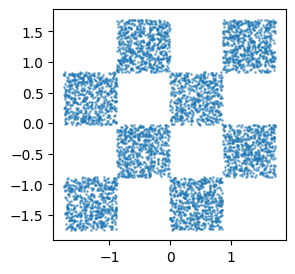

In [164]:
plt.figure(figsize=(3, 3))
plt.scatter(train_data.numpy()[:,0], train_data.numpy()[:,1], s=1.0, alpha=0.5)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular region of space. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

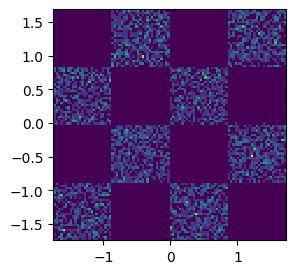

In [165]:
plt.figure(figsize=(3, 3))
plt.hist2d(train_data.numpy()[:,0], train_data.numpy()[:,1], bins=100)
plt.show()

#### Moon (use this one only if your models struggle on checkerboard)

In [166]:
# import torch
# import math
# from sklearn import datasets
# import numpy as np


# # Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# # an infinite-size dataset
# def generate_batch(batchlen):
#     """This function generates a batch of length 'batchlen' from the dataset
#     """
#     data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
#     return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

In [167]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# batch = generate_batch(5000)

# plt.scatter(batch[:,0], batch[:,1], s=2.0)
# plt.show()

It's also good to visualize the density as sometimes generative models overfit particular areas. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

In [168]:
# plt.hist2d(batch.numpy()[:,0], batch.numpy()[:,1], bins=100)
# plt.xlim([-1.2,2.2])
# plt.ylim([-0.7,1.2])
# plt.show()

----
### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> With a larger dimension of the input noise $\epsilon$, we force the model to learn a more complex function $f_\theta$ with inputs in a higher-dimensional latent space. This can be beneficial when we need to model complex distributions (e.g., images once again), but can also lead to overfitting if the dimension is too high as compared to the task at hand. Studies have shown that the choice of the dimension of the input noise can have a significant impact on the quality of the generated samples, and that the optimal dimension is often problem-dependent [[Manisha et al., 2020](https://arxiv.org/pdf/2004.06882.pdf)].

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> A pitfall linked to a training using the JS-divergence as loss is that, as mentioned in Question 1, such distance will strongly penalize disjoint supports. Given the fact that the generator is trained with noise as input, we expect it to behave very badly at the beginning of the training with potentially a very restricted overlap between the supports of the generated and real distributions (worsening with the dimension). In such setting, the JS-divergence will take values close to 0, making its contribution to the gradient almost useless (i.e., vanishing gradients).

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> The training does not try to learn the density of the target distribution, but rather ressembles a min-max game (the loss can rewritten as such), where the generator tries to generate samples that are indistinguishable from the real data, while the discriminator tries to distinguish between the two. A potential issue with this approach is that is very sensitive due to its game-theoretic nature: if at some point the generator becomes good too quickly, the balance between the two networks will be broken. The discriminator will not be able to distinguish between the two distributions and will give useless feedback to the generator (as it is constantly fooled). On the other hand, if the discriminator becomes too good too quickly, the generator will not be able to adapt and will fail to generate realistic samples. <br>
> Another consideration is that, since we do not model densities, the generator might focus too much on fooling the discriminator: instead of learning a good representation of the distribution over the entire support, it might favour generating samples that the discriminator cannot distinguish from the real data. This lack of exploration is knonwn as "mode collapse".

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [272]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self, PRIOR_N=PRIOR_N):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        
    def __call__(self, z):
        return self.fc1(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, n_hid=10):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()
    
    def __call__(self, x):
        return self.sigmoid(self.fc1(x))

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

In [276]:
def generation_training(generator, discriminator, 
                        TRAIN_RATIO, 
                        N_ITER, 
                        BATCHLEN, 
                        lr_gen, 
                        lr_disc,
                        plots = True,
                        losses = True):
    
    optim_gen = torch.optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5,0.9))    
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5,0.9))

    if N_ITER < 5000:
        raise ValueError('N_ITER should be at least 5000')
    if N_ITER == 5000:
        interest = [1, 1000, 2000, 5000]
    else:
        interest = [1, 1000, 2000, 5000, N_ITER]
    fig, ax = plt.subplots(1, len(interest), figsize=(15, 3))
    idx = 0

    gen_losses = []
    disc_losses = []

    for i in tqdm.tqdm(range(N_ITER)):
        # train the discriminator
        for _ in range(TRAIN_RATIO):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = generator.generate(BATCHLEN)
            # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
            Dreal = discriminator(real_batch)
            Dfake = discriminator(fake_batch.detach())
            disc_loss = torch.mean(- torch.log(Dreal)) + torch.mean(- torch.log(1 - Dfake))
            disc_loss.backward()
            optim_disc.step()
        disc_losses.append(disc_loss.item())
        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        # == COMPUTE THE GENERATOR LOSS HERE
        Dfake = discriminator(fake_batch)
        # gen_loss = torch.mean(torch.log(1 - Dfake))
        ## Replacing with non-saturating loss ##
        gen_loss = torch.mean(- torch.log(Dfake))
        gen_losses.append(gen_loss.item())
        gen_loss.backward()
        optim_gen.step()
        if (i+1) in interest:
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach()
            ax[idx].scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            ax[idx].scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            ax[idx].legend(prop={'size': 6})
            ax[idx].set_title('step {}'.format(i+1))
            idx += 1
    plt.show()
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax[0].plot(disc_losses)
        ax[0].set_title('Discriminator loss')
        ax[0].set_xlabel('iteration')
        ax[1].plot(gen_losses)
        ax[1].set_title('Generator loss')
        ax[1].set_xlabel('iteration')
        plt.show()

    return gen_losses, disc_losses, generator, discriminator


def compare_densities(generator):
    real_batch = generate_batch(5000)
    fake_batch = generator.generate(5000).detach()
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].hist2d(real_batch.numpy()[:,0], real_batch.numpy()[:,1], bins=100)
    ax[0].set_title('Real data')
    ax[0].set_xlim(-2, 2)
    ax[0].set_ylim(-2, 2)
    ax[1].hist2d(fake_batch.numpy()[:,0], fake_batch.numpy()[:,1], bins=100)
    ax[1].set_xlim(-2, 2)
    ax[1].set_ylim(-2, 2)
    ax[1].set_title('Fake data')
    fig.suptitle('Real and fake data distributions')
    plt.show()


  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:05<00:00, 3354.09it/s]


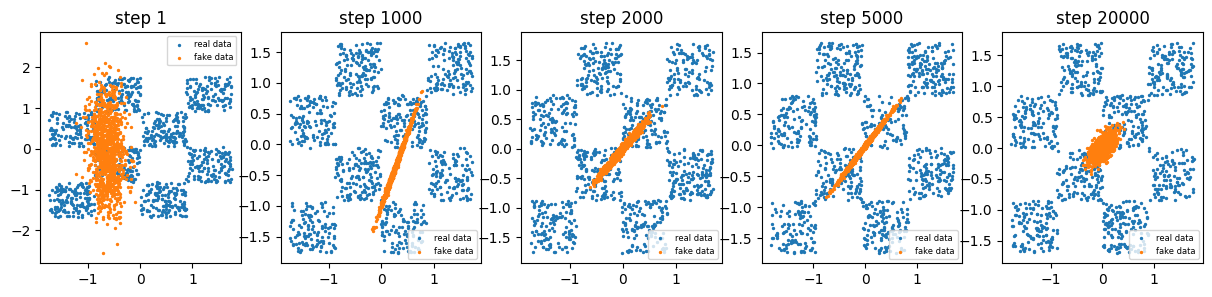

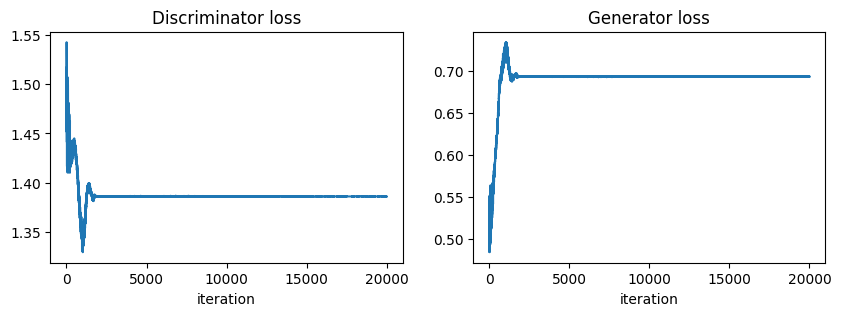

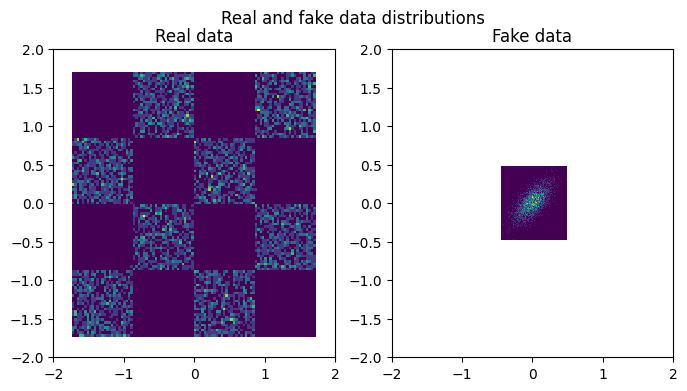

In [277]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
# N_ITER = 20001
N_ITER = 20000
# Batch size to use
BATCHLEN = 128

lr_gen = 1e-3
lr_disc = 1e-3

generator = Generator()
discriminator = Discriminator()

gen_losses, disc_losses, generator, discriminator = generation_training(generator = generator, discriminator = discriminator,
                                                                        TRAIN_RATIO = TRAIN_RATIO, 
                                                                        N_ITER = N_ITER, 
                                                                        BATCHLEN = BATCHLEN, 
                                                                        lr_gen = lr_gen, 
                                                                        lr_disc = lr_disc,
                                                                        plots = True)

compare_densities(generator)

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> Such behavior could be anticipated (partly discussed in the previous questions) due to the nature of the loss. Originally, both the generator and the discriminator are trained to respectively minimize and maximize the aforementioned cross-entropy term (with an additional term for the discriminator). As a consequence, when the discriminator is able to reject generated samples with high confidence, the generator will receive gradients close to zero, and will not be able to learn from the feedback [[Goodfellow et al., 2016](https://arxiv.org/pdf/1701.00160.pdf)].

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> The initial results are clearly not satisfying. The generator is not able to learn a relevant mapping and the generated samples are not close to the real data distribution. To address this issue, we define new architectures for the generator and the discriminator in order to compare the changes as a function of the depth and width of the networks.

In [291]:
# These architectures are largely inspired from a practical session of the course "Generative Modeling for Images" (B. Galerne & A. Leclaire, MVA) 

class Generator(nn.Module):
    def __init__(self, n_in = PRIOR_N, n_out = 2, n_hid = 10, nlayers = 3, device = torch.device("cpu")):
        super().__init__()
    
        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Linear(n_hid, n_out).to(device)

        self.apply(self._init_weights)
        
    def __call__(self, z):
        for n in range(self.nlayers):
            z = self.hidden[n](z)
        x = self.out(z)
        return x
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()

class Discriminator(nn.Module):
    def __init__(self, n_hid=10, nlayers=3):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.n_in = 2
        self.n_out = 1
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = self.n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.LeakyReLU(0.2)
        ).to(device))

        self.out = nn.Linear(n_hid, self.n_out).to(device)

    def __call__(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        y = self.out(x)
        return self.sigmoid(y)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [01:18<00:00, 255.26it/s]


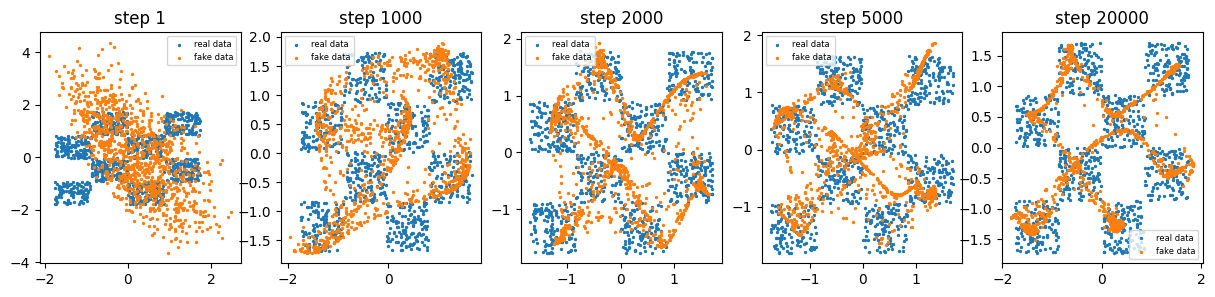

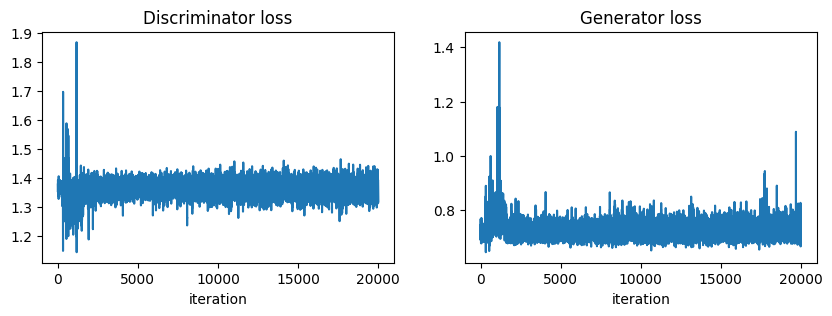

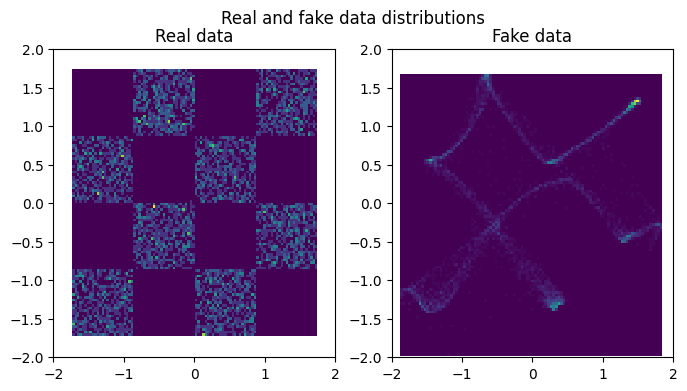

In [281]:
TRAIN_RATIO = 5
N_ITER = 20000
BATCHLEN = 128

lr_gen = 5e-3
lr_disc = 1e-3

generator = Generator(n_hid=128, nlayers=3, device=device)
discriminator = Discriminator(n_hid=32)

gen_losses, disc_losses, generator, discriminator = generation_training(generator = generator, discriminator = discriminator,
                                                                        TRAIN_RATIO = TRAIN_RATIO, 
                                                                        N_ITER = N_ITER, 
                                                                        BATCHLEN = BATCHLEN, 
                                                                        lr_gen = lr_gen, 
                                                                        lr_disc = lr_disc,
                                                                        plots = True
                                                                        )

compare_densities(generator)

----------------------
# Generator Architecture #
----------------------

Generator with hidden size 2 and 1 layers


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:09<00:00, 552.31it/s]


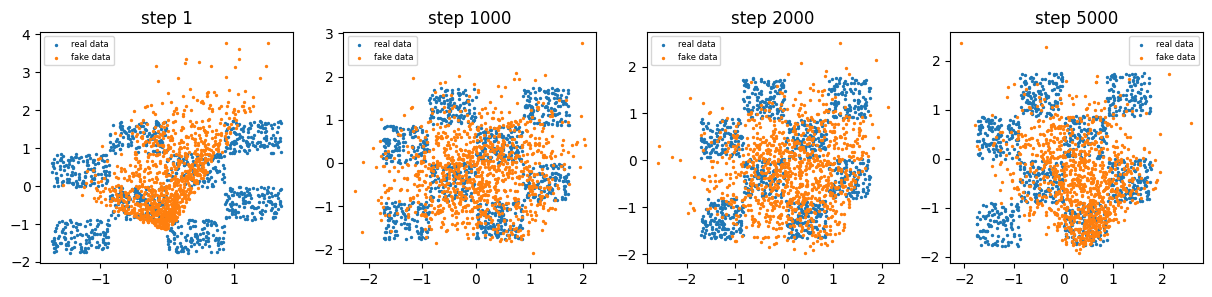

Generator with hidden size 2 and 3 layers


100%|██████████| 5000/5000 [00:09<00:00, 511.79it/s]


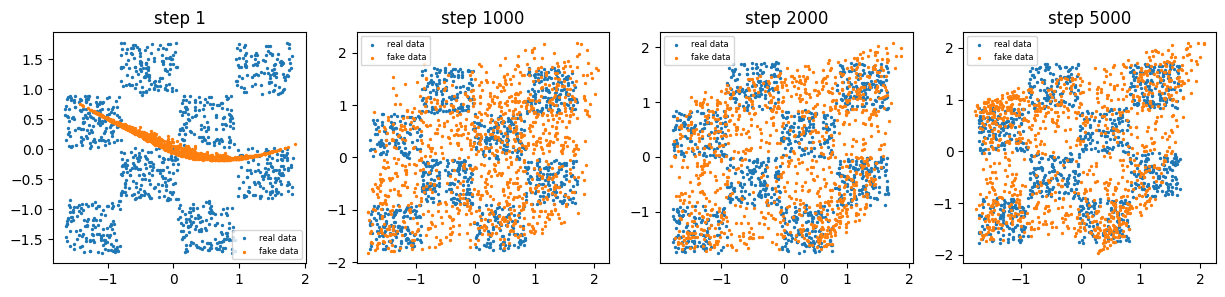

Generator with hidden size 2 and 10 layers


100%|██████████| 5000/5000 [00:12<00:00, 394.14it/s]


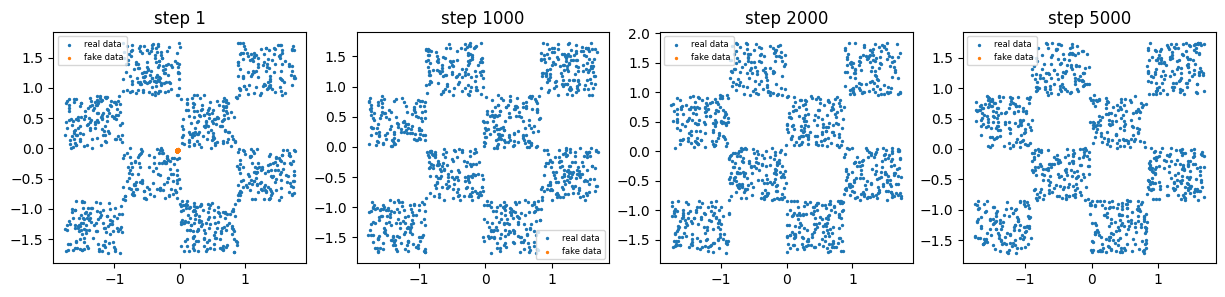

Generator with hidden size 32 and 1 layers


100%|██████████| 5000/5000 [00:09<00:00, 521.93it/s]


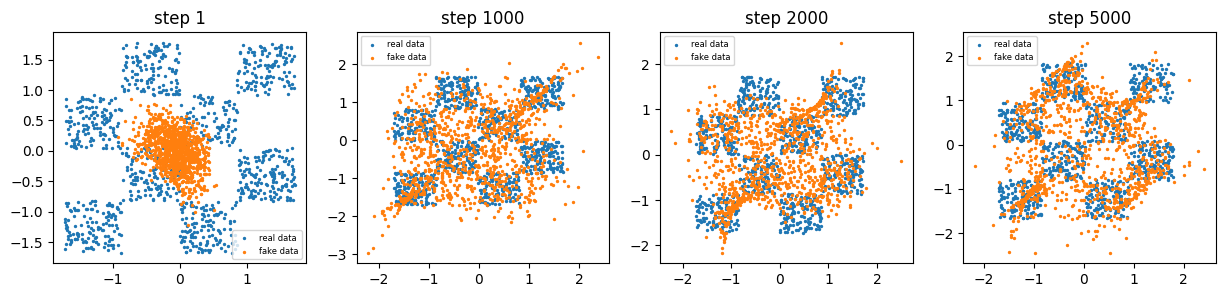

Generator with hidden size 32 and 3 layers


100%|██████████| 5000/5000 [00:10<00:00, 461.38it/s]


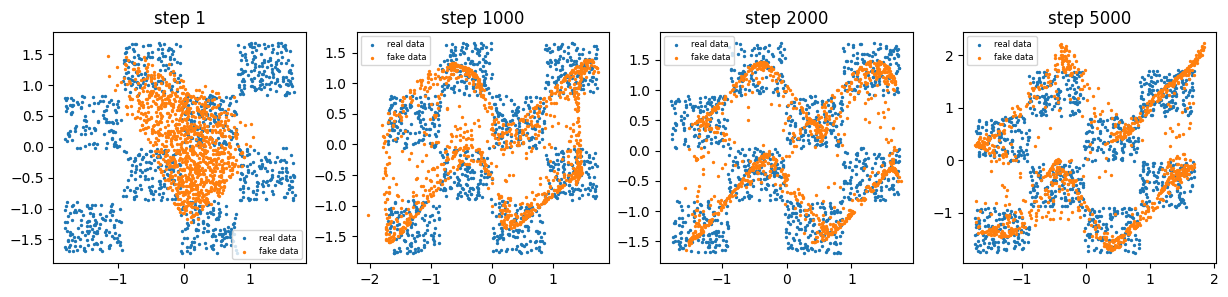

Generator with hidden size 32 and 10 layers


100%|██████████| 5000/5000 [00:16<00:00, 309.99it/s]


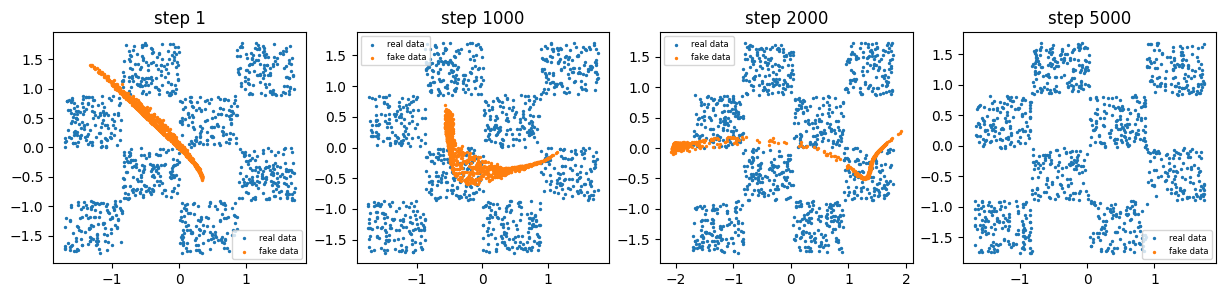

Generator with hidden size 128 and 1 layers


100%|██████████| 5000/5000 [00:10<00:00, 495.80it/s]


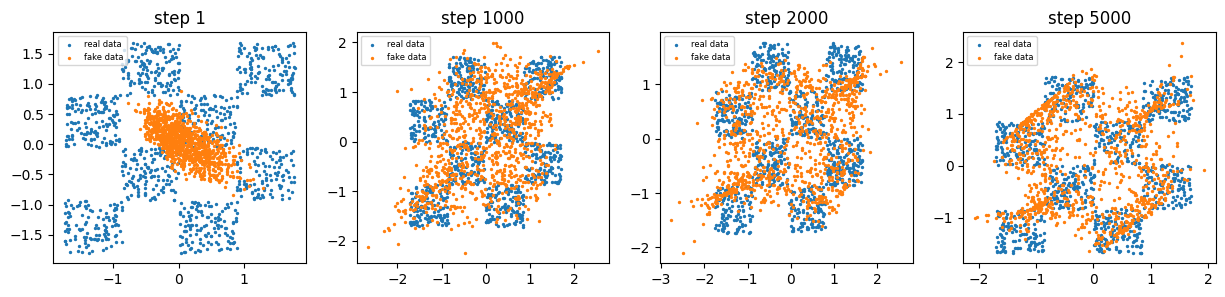

Generator with hidden size 128 and 3 layers


100%|██████████| 5000/5000 [00:14<00:00, 344.49it/s]


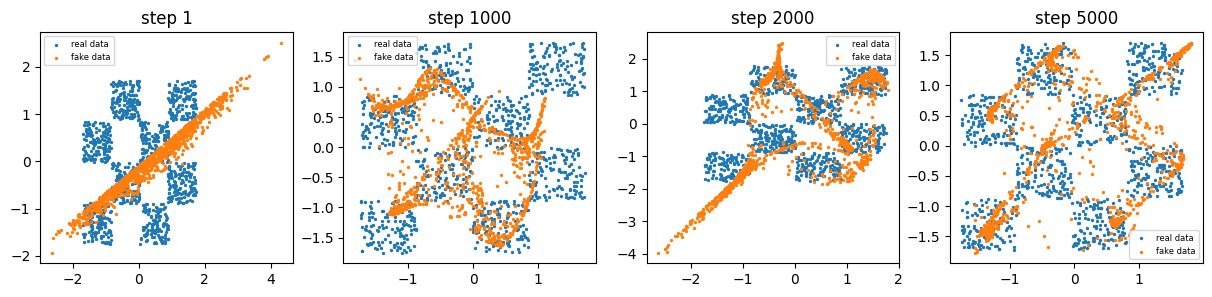

Generator with hidden size 128 and 10 layers


100%|██████████| 5000/5000 [00:29<00:00, 167.00it/s]


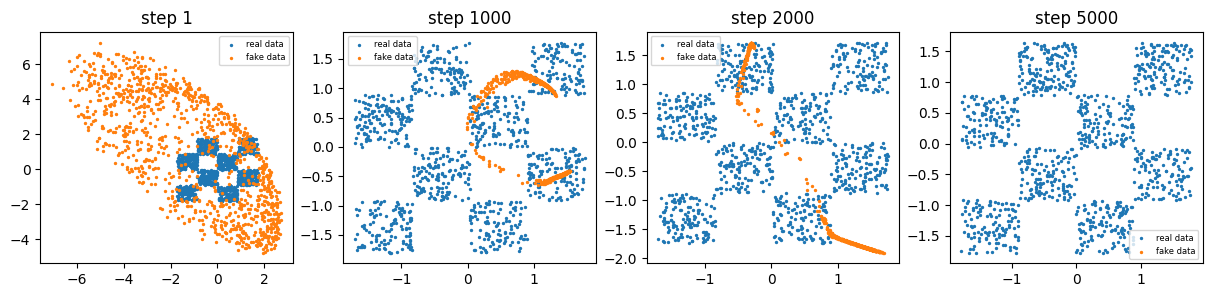

In [296]:
TRAIN_RATIO = 3
N_ITER = 5000
BATCHLEN = 128

lr_gen = 5e-3
lr_disc = 1e-3


genhid = [2, 32, 128]
nlayers = [1, 3, 10]

for hid in genhid:
    for nl in nlayers:
        generator = Generator(n_hid=hid, nlayers=nl, device=device)
        discriminator = Discriminator(n_hid=32, nlayers=3)
        print('Generator with hidden size {} and {} layers'.format(hid, nl))
        gen_losses, disc_losses, generator, discriminator = generation_training(generator = generator, discriminator = discriminator,
                                                                        TRAIN_RATIO = TRAIN_RATIO, 
                                                                        N_ITER = N_ITER, 
                                                                        BATCHLEN = BATCHLEN, 
                                                                        lr_gen = lr_gen, 
                                                                        lr_disc = lr_disc,
                                                                        plots = True,
                                                                        losses = False)

----------------------
# Discriminator Architecture #
----------------------

Discriminator with hidden size 2 and 1 layers


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:07<00:00, 697.24it/s]


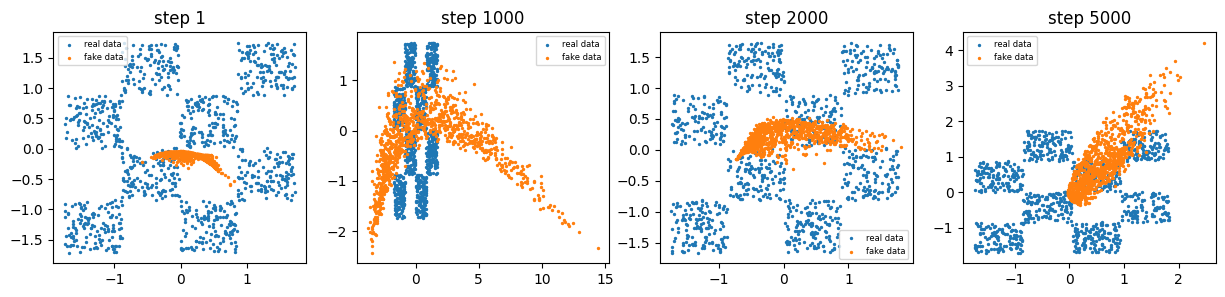

Discriminator with hidden size 2 and 3 layers


100%|██████████| 5000/5000 [00:09<00:00, 519.34it/s]


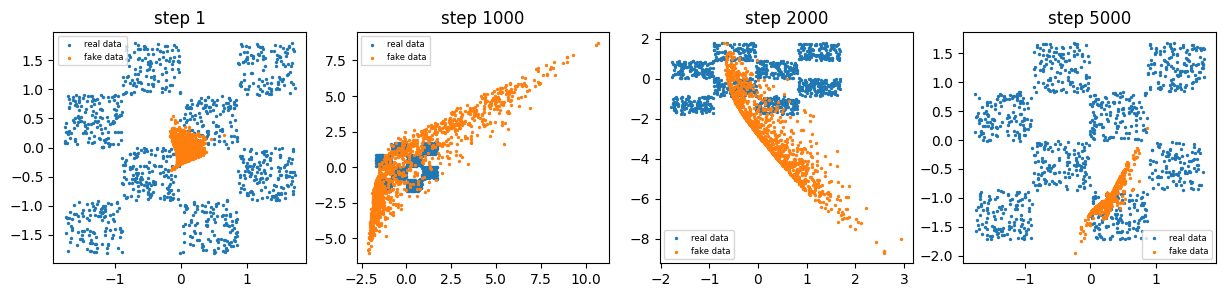

Discriminator with hidden size 2 and 10 layers


100%|██████████| 5000/5000 [00:18<00:00, 275.56it/s]


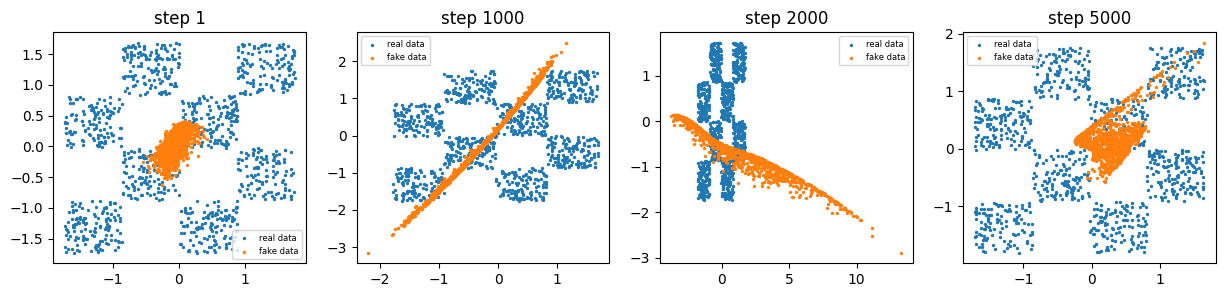

Discriminator with hidden size 32 and 1 layers


100%|██████████| 5000/5000 [00:07<00:00, 647.53it/s]


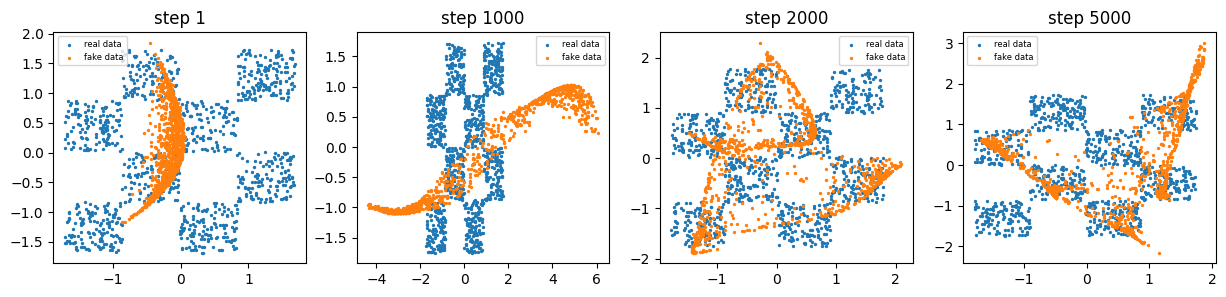

Discriminator with hidden size 32 and 3 layers


100%|██████████| 5000/5000 [00:11<00:00, 450.13it/s]


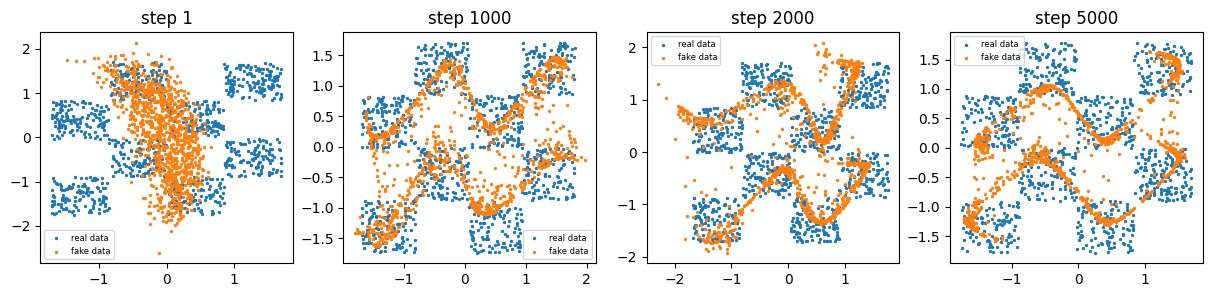

Discriminator with hidden size 32 and 10 layers


100%|██████████| 5000/5000 [00:21<00:00, 230.64it/s]


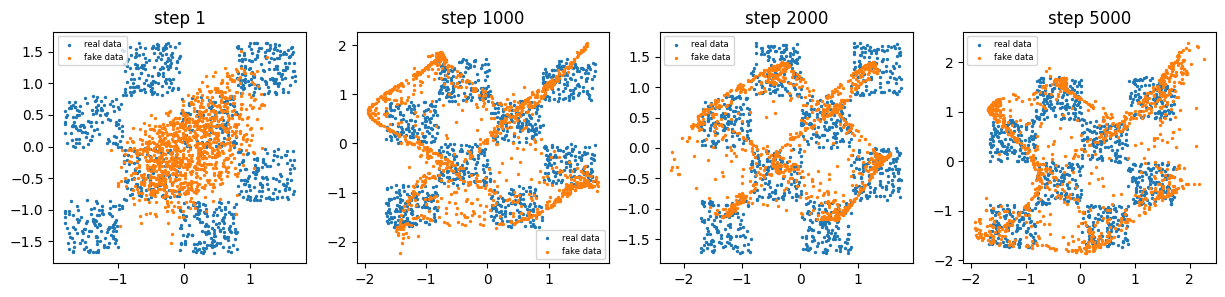

Discriminator with hidden size 128 and 1 layers


100%|██████████| 5000/5000 [00:08<00:00, 583.99it/s]


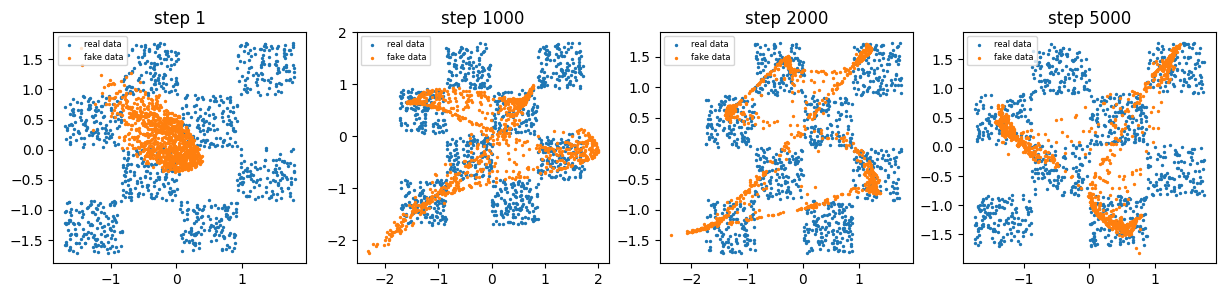

Discriminator with hidden size 128 and 3 layers


100%|██████████| 5000/5000 [00:17<00:00, 293.84it/s]


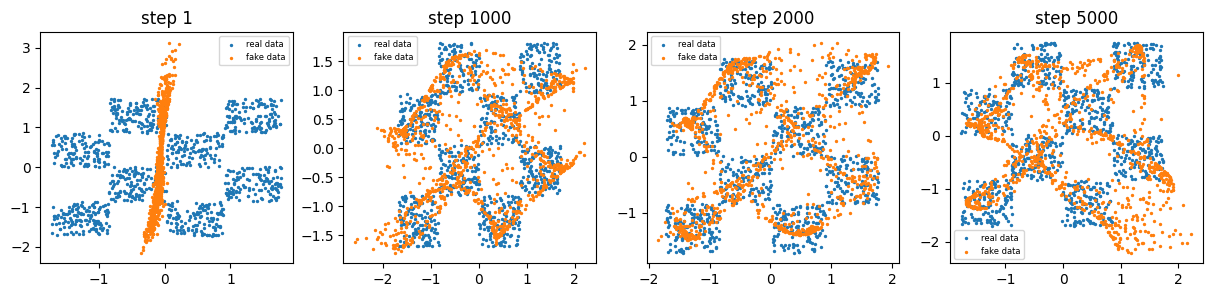

Discriminator with hidden size 128 and 10 layers


100%|██████████| 5000/5000 [00:44<00:00, 112.04it/s]


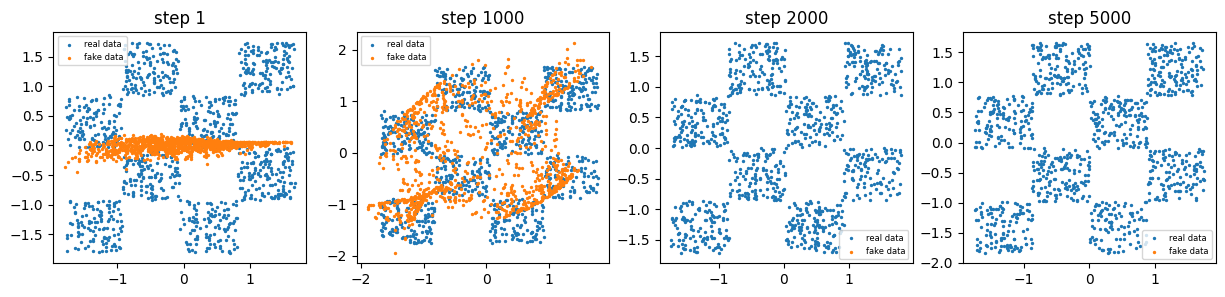

In [297]:
TRAIN_RATIO = 3
N_ITER = 5000
BATCHLEN = 128

lr_gen = 5e-3
lr_disc = 1e-3

disc_hid = [2, 32, 128]
nlayers = [1, 3, 10]

for hid in disc_hid:
    for nl in nlayers:
        generator = Generator(n_hid=32, nlayers=3, device=device)        
        discriminator = Discriminator(n_hid=hid, nlayers=nl)
        print('Discriminator with hidden size {} and {} layers'.format(hid, nl))
        gen_losses, disc_losses, generator, discriminator = generation_training(generator = generator, discriminator = discriminator,
                                                                        TRAIN_RATIO = TRAIN_RATIO, 
                                                                        N_ITER = N_ITER, 
                                                                        BATCHLEN = BATCHLEN, 
                                                                        lr_gen = lr_gen, 
                                                                        lr_disc = lr_disc,
                                                                        plots = True,
                                                                        losses = False)

----------------------
# Training Ratio #
----------------------

Training Ratio: 1


  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:20<00:00, 956.69it/s]


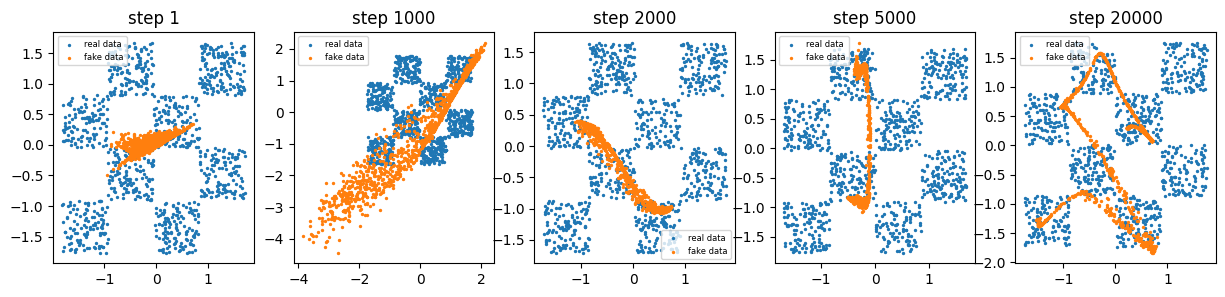

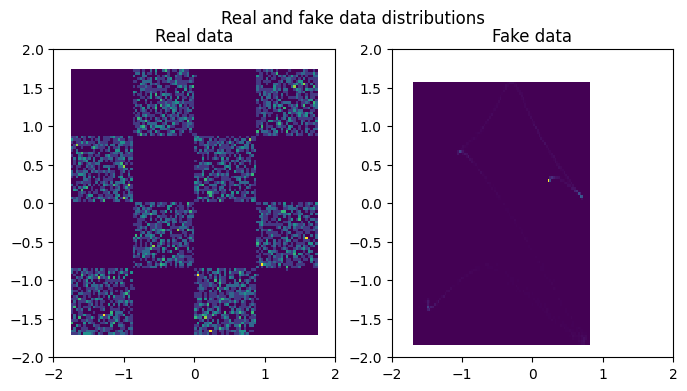

Training Ratio: 2


100%|██████████| 20000/20000 [00:31<00:00, 636.98it/s]


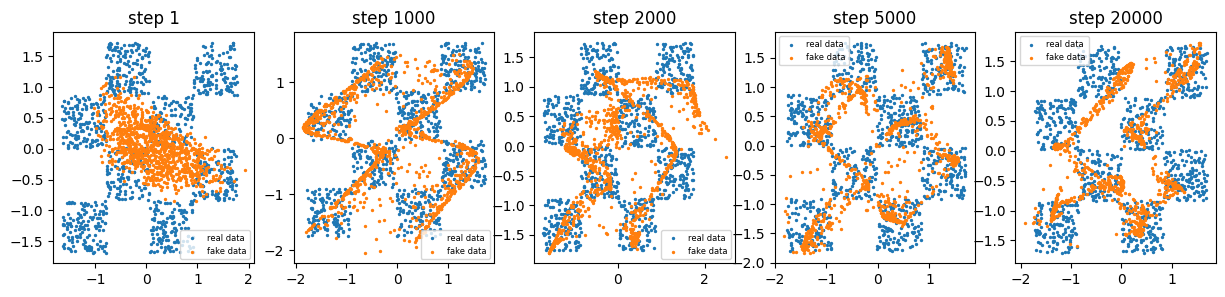

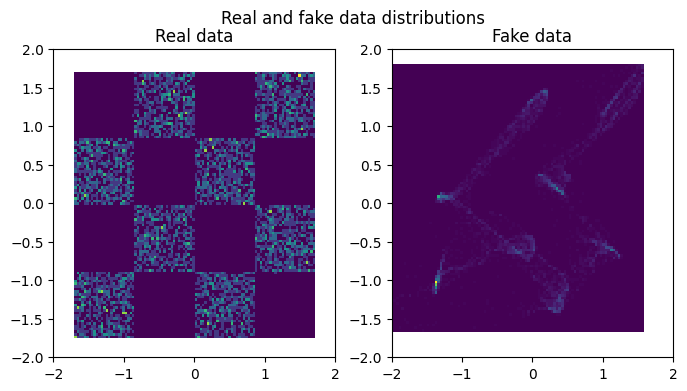

Training Ratio: 10


100%|██████████| 20000/20000 [02:00<00:00, 165.39it/s]


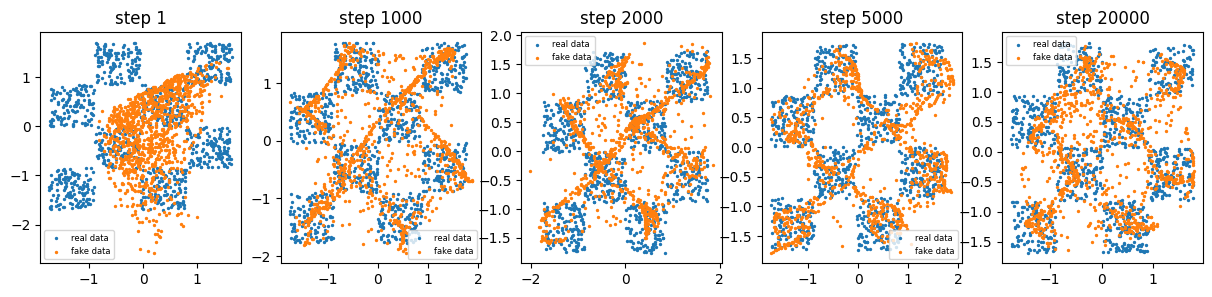

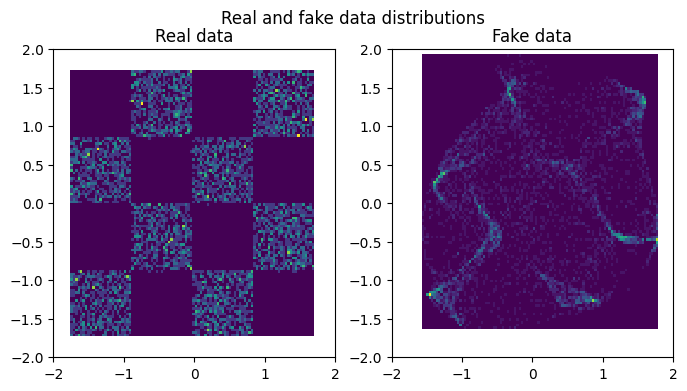

Training Ratio: 50


100%|██████████| 20000/20000 [09:13<00:00, 36.15it/s]


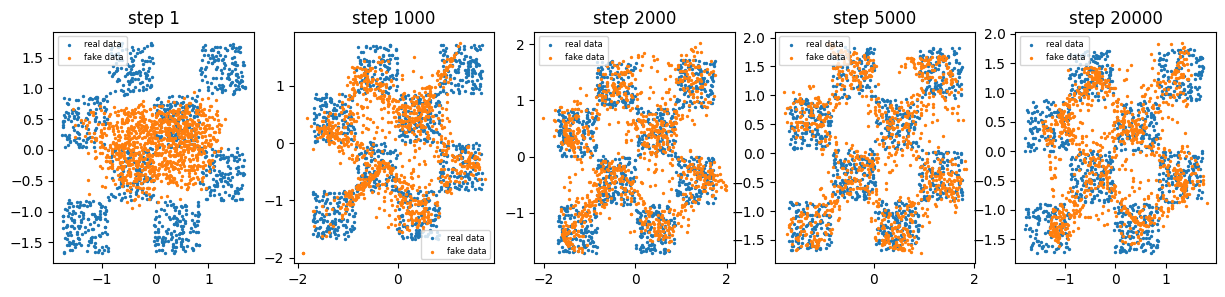

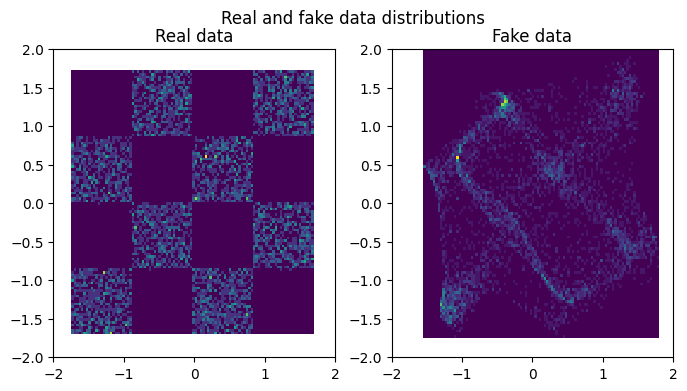

In [302]:
N_ITER = 20000
BATCHLEN = 128

lr_gen = 5e-3
lr_disc = 1e-3

training_ratios = [1, 2, 10, 50]

for ratio in training_ratios:
    generator = Generator(n_hid=32, nlayers=3, device=device)
    discriminator = Discriminator(n_hid=32, nlayers=3)
    print('Training Ratio:', ratio)
    gen_losses, disc_losses, generator, discriminator = generation_training(generator = generator, discriminator = discriminator,
                                                                    TRAIN_RATIO = ratio, 
                                                                    N_ITER = N_ITER, 
                                                                    BATCHLEN = BATCHLEN, 
                                                                    lr_gen = lr_gen, 
                                                                    lr_disc = lr_disc,
                                                                    plots = True,
                                                                    losses = False)
    compare_densities(generator)

> From these observations, we can draw as conclusions that the depth and width of the networks have a significant impact on the quality of the generated samples. Networks too shallow are not expressive enough and cannot learn a good representation of the data distribution. On the other hand, networks too deep were inefficient (this might be due to a lack of individual tuning, for the learning rates for example). The width of the networks seems to be improve considerably the performance up to a point (we do not notice a significant improvement between 32 and 128 hidden units). Finally, the generator and discriminator seemed to require a balance in terms of complexity (probably to avoid one network overpowering the other, cf. previous questions).<br>
> The training ratio is a crucial hyperparameter to tune. We notice that a training ratio of 1 is not enough to stabilize the training, but did not notice a significant change in the density estimations between 5 and 10. 

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

----
### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> (Write your answer here)

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](./vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> (Write your answer here, what will be the influence on data generation by VAE)

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> (Write your answer here)

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> (Write your answer here)

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    z = 0
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

> (Write your answer here, observe the plots)

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> (Write your answer here)

---
### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> Let $h$ be a bounded and measurable function. On one hand, we have:
> \begin{align*}
> \mathbb{E}_{p_X}[h(X)] = \int h(x) p_X(x) dx.
> \end{align*}
> On the other hand, using the change of variable theorem, we can write:
> \begin{align*}
> \mathbb{E}_{p_X}[h(X)] = \mathbb{E}_{p_Z}[h(f^{-1}(Z))] = \int h(f^{-1}(z)) p_Z(z) dz = \int h(x) p_Z(f(x)) |J_f(x)| dx.
> \end{align*}
> By identifying the two expressions, we get:
> \begin{align*}
> \int h(x) p_X(x) dx = \int h(x) p_Z(z) |J_f(x)| dx \iff p_X(x) = p_Z(z) |J_f(x)|.
> \end{align*}
> Finally, by taking the logarithm, we get:
> \begin{align*}
> \log p_X(x) = \log p_Z(z) + \log |J_f(x)|.
> \end{align*}

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> We have that:
> \begin{align*}
> KL(p_D||p_G) &= \mathbb{E}_{p_D}[\log p_D(x) - \log p_G(x)] \\
> &= \mathbb{E}_{p_D}[\log p_D(x) - \log p_Z(f(x)) - \log |J_f(x)|] \\
> &= \mathbb{E}_{p_D}[\log p_D(x)] - \mathbb{E}_{p_D}[\log p_Z(f(x)) - \log |J_f(x)|].
> \end{align*}
> Our objective will be to find the mapping $f$ that minimizes the second term of this divergence

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](./realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> We pose the notations $x_0 = x_{1:d}$ and $x_1 = x_{d+1:D}$.
> We can then write:
> \begin{align}
> f(x) = y & \iff \begin{pmatrix} x_0 \\ x_1 \odot \exp(s(x_0)) + t(x_0) \end{pmatrix} = \begin{pmatrix} y_0 \\ y_1 \end{pmatrix} \\
> & \iff \begin{cases} x_0 = y_0 \\ x_1 \odot \exp(s(x_0)) = y_1 - t(x_0) \end{cases} \\
> & \iff \begin{cases} x_0 = y_0 \\ x_1 = (y_1 - t(x_0)) \odot \exp(-s(x_0)) \end{cases}
> \end{align}
> Given that $ x \mapsto \exp(x)$ is invertible, the mapping $f$ is indeed invertible.

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> We define the Jacobian of the mapping $f$ as:
> \begin{align}
> J_f(x) & = \begin{pmatrix} \frac{\partial y_0}{\partial x_0} & \frac{\partial y_0}{\partial x_1} \\ \frac{\partial y_1}{\partial x_0} & \frac{\partial y_1}{\partial x_1} \end{pmatrix} = \begin{pmatrix} I_d & 0 \\ \frac{\partial y_1}{\partial x_0} & \frac{\partial y_1}{\partial x_1} \end{pmatrix} = \begin{pmatrix} I_d & 0 \\ \frac{\partial y_1}{\partial x_0} & \text{diag}[\exp(s(x_0))] \end{pmatrix} \\
> \end{align}
> Its determinant can thus be written as the determinant of a diagonal matrix, that is:
> \begin{align}
> \det J_f(x) = \exp \left(\sum_j s(x_0)_j \right).
> \end{align}

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [326]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.scale = nn.Sequential(nn.Linear(input_size, hidden_size),
                                   nn.LeakyReLU(),
                                   nn.Linear(hidden_size, hidden_size),
                                   nn.LeakyReLU(),
                                   nn.Linear(hidden_size, hidden_size),
                                   nn.LeakyReLU(),
                                   nn.Linear(hidden_size, output_size),
                                   nn.Tanh())

        self.translate = nn.Sequential(nn.Linear(input_size, hidden_size),
                                   nn.LeakyReLU(),
                                   nn.Linear(hidden_size, hidden_size),
                                   nn.LeakyReLU(),
                                   nn.Linear(hidden_size, hidden_size),
                                   nn.LeakyReLU(),
                                   nn.Linear(hidden_size, output_size)
                                   )

        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        x_m = self.scale(x_m)
        return x_m
        
    def tfun(self, x_m):
        x_m = self.translate(x_m)
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = self.sfun(y_m)
        t_out = self.tfun(y_m)
        y = y_m + (1-self.mask)*((y-t_out)*torch.exp(-s_out))
        return y

In [327]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [328]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [329]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [330]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [331]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(input_size = INPUT_SIZE, output_size=OUTPUT_SIZE, hidden_size=HIDDEN_SIZE, mask=mask, n_layers=N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.018160
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.042459
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.051695
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.053963
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.054685
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.056281
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.056487
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.056858
====> Epoch: 1 Average train loss: -0.0492


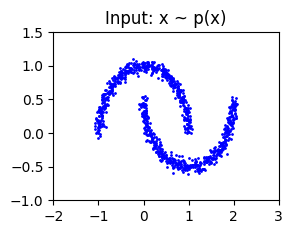

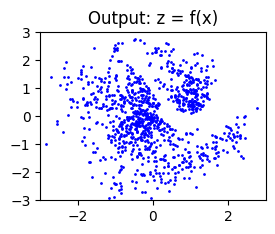

====> Test loss: -0.0586


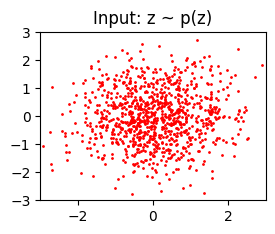

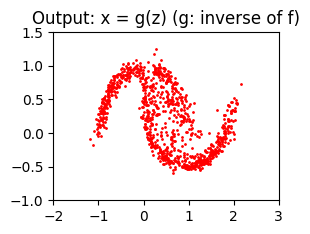

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.058167
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.057626
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.057747
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.058357
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.058652
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.059114
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.057686
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.058744
====> Epoch: 2 Average train loss: -0.0582


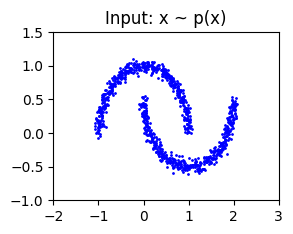

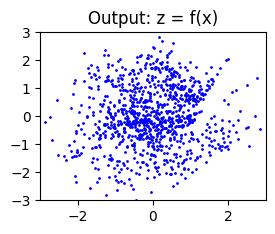

====> Test loss: -0.0603


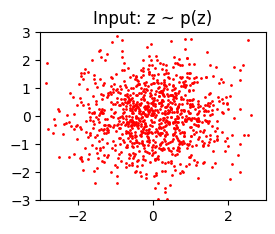

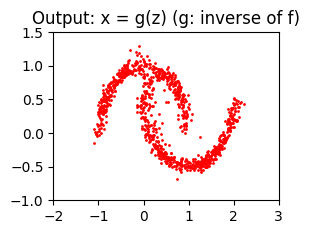

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.058640
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.059874
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.058568
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.058637
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.058908
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.058270
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.059048
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.058841
====> Epoch: 3 Average train loss: -0.0587


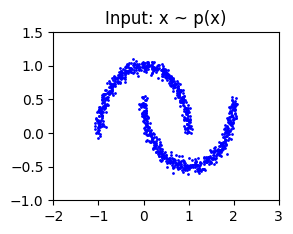

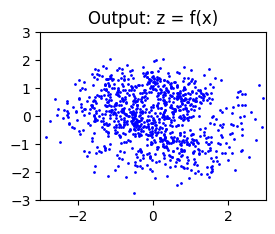

====> Test loss: -0.0604


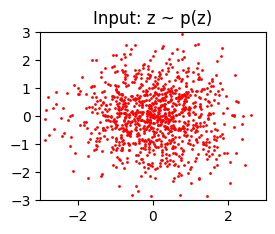

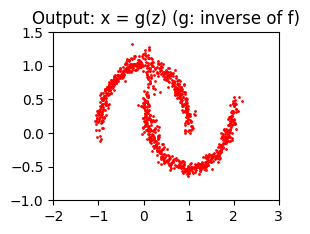

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.058768
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.058225
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.059337
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.058306
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.058917
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.059011
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.058655
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.057815
====> Epoch: 4 Average train loss: -0.0588


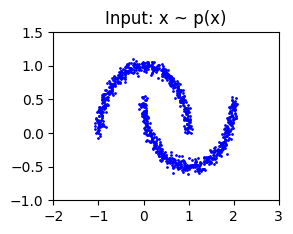

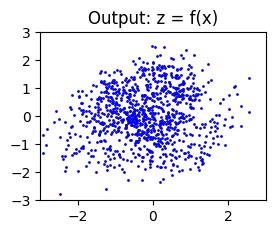

====> Test loss: -0.0606


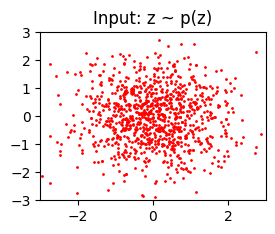

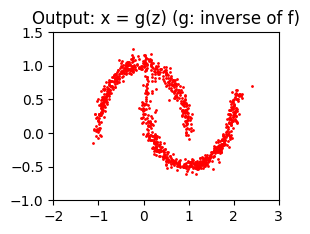

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059758
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.059715
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.059299
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.057929
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.058297
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.058782
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.059609
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.058819
====> Epoch: 5 Average train loss: -0.0591


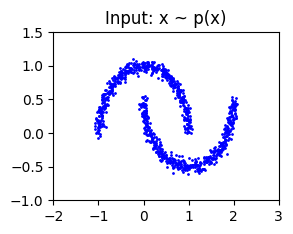

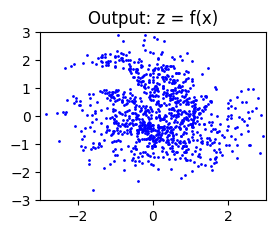

====> Test loss: -0.0599


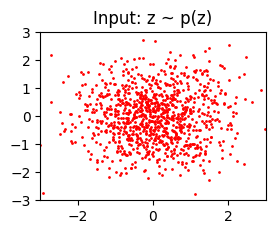

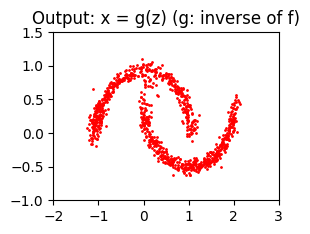

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.057903
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.059300
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.059271
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.058878
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.059149
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.059119
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.058952
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.058611
====> Epoch: 6 Average train loss: -0.0591


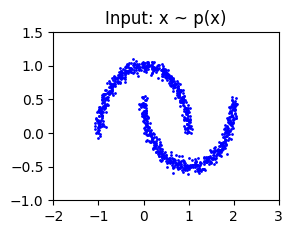

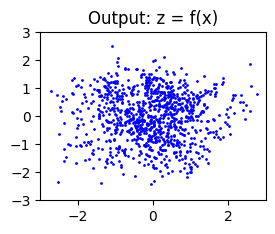

====> Test loss: -0.0608


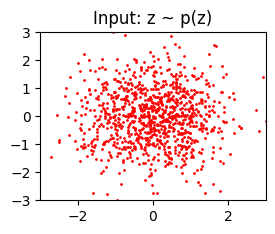

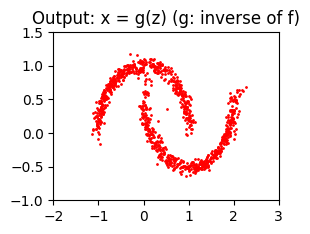

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.059795
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.059282
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.059065
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.059053
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.059468
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.059427
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.058156
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.059645
====> Epoch: 7 Average train loss: -0.0592


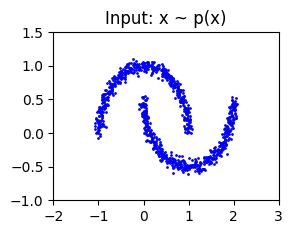

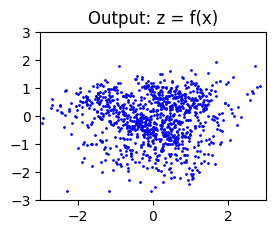

====> Test loss: -0.0601


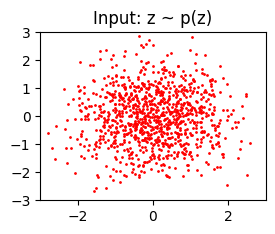

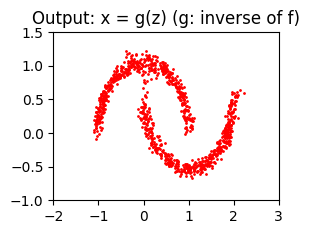

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.059307
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.058897
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.058852
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.058402
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.057714
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.059191
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.057927
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.059863
====> Epoch: 8 Average train loss: -0.0593


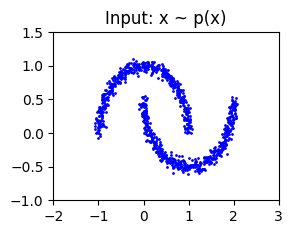

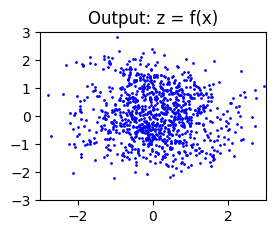

====> Test loss: -0.0610


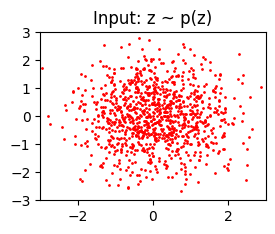

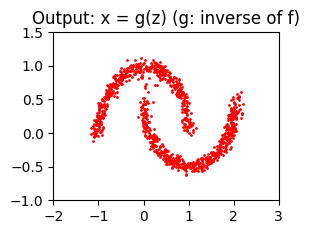

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.059336
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.059718
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.059651
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.060219
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.059338
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.059219
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.058949
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.059043
====> Epoch: 9 Average train loss: -0.0594


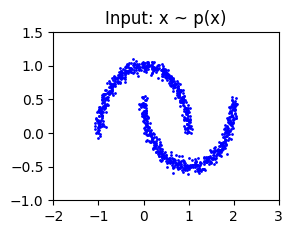

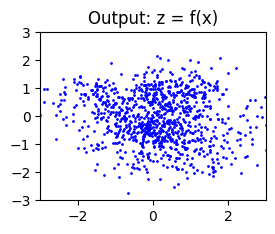

====> Test loss: -0.0607


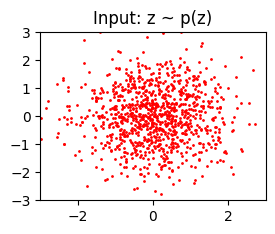

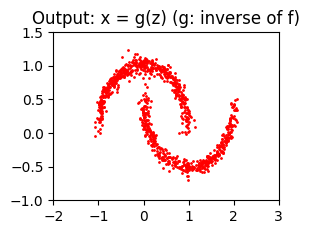

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.059481
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.058494
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.058022
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.060057
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059986
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.060750
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.058798
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.059503
====> Epoch: 10 Average train loss: -0.0594


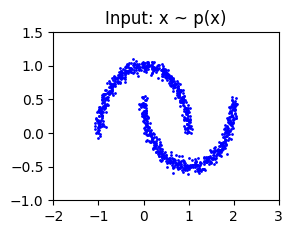

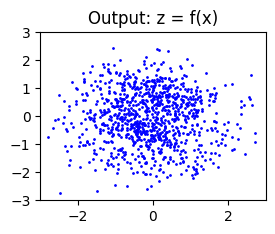

====> Test loss: -0.0613


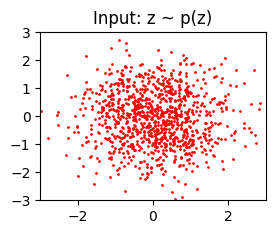

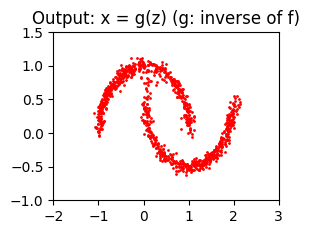

'60.62s'

<Figure size 640x480 with 0 Axes>

In [332]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> While this method relies on finding smooth and invertible transformations to map the data distribution to a known distribution, multiple clusters in the data distribution usually create discontinuities that are hard to model. We notice on the generated samples that the model seems to seek for a fixing point between the two moons (here the vertical line at x = 0), as a way of moving from one cluster to the other. 

---
## Denoising Diffusion Model

Recently Diffusion Models received a lot of attention. __Diffusion Models Beat GANs on Image Synthesis__ *(Dhariwal,Nichol)* : [arXiv:2105.05233](https://arxiv.org/pdf/2105.05233.pdf) shows significant improvement on image generation with a model claimed to be easier to train than GANs.


It is the key of the image generating process behind Latent Diffusion models such as Dall.e, Imagen or StableDiffusion. 

We are going to implement a model inspired by the paper
__Denoising Diffusion Probabilistic Models__  *(Ho et al.)*: [arXiv:2006.11239](https://arxiv.org/pdf/2006.11239.pdf) 


 Denoising diffusion probabilistic model  introduce noise into data and gradually learn to reverse this process for generating new samples. It involves two Markov chains, one that forwards data to noise, and another that reverses this process by converting the noise back to data. The forward chain is usually designed to transform any data distribution into a simpler prior distribution, such as a standard Gaussian distribution, while the reverse Markov chain is parametrized by a neural network and learns to reverse this process. To generate new data points, we first sample a random vector from the prior distribution, then applies ancestral sampling through the reverse Markov chain.

 References:

- Survey on Diffusion Models : https://arxiv.org/pdf/2209.00796.pdf
- https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
- https://blog.alexalemi.com/diffusion.html
- https://sander.ai/posts/



![Denoisingdiagram](./illustrationDenoising.png)

$q$ and $p_{\theta}$ being the respective kernels of the two chains. 


#### Forward Pass ####

For our purpose we are going to use a Gaussian Noise. The forward Kernel will have the following shape : 

$$q(x_t| x_{t-1}) = \mathcal{N}(x_t;\sqrt{1- \beta_t} x_{t-1},\beta_t I )$$

with $\mathcal{N}(x;\mu,\sigma I )$ a conditional gaussian :
$$ y \sim \mathcal{N}(x;\mu,\sigma I ) \equiv y|x \sim  \mathcal{N}(\mu,\sigma I )$$

**Q20: What does $\beta_t$ represent in the formula ?**

> (Write your answer here)

In our example the sequence $\beta_t$ will be chosen linearly wrt $t$. 

We introduce $\alpha_t := 1-\beta_t$ and $\overline{\alpha_t} = \prod_{s=1}^{t} \alpha_s$ we can sample forward directly at timestep $t$ from the original image : 
$$q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t=1}^{T}q(\mathbf{x}_t|\mathbf{x}_{t-1})$$
$$ q(\mathbf{x}_t| \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\sqrt{\overline{\alpha_t}} \mathbf{x}_0, (1-\overline{\alpha_t})I)$$

i.e. 
\begin{align}
\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon} \;\;\; \text{where} \; \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
\end{align}

we will then fix $$\sigma_t = \sqrt{1 - \bar{\alpha}_t}$$

**Q22:  Implement the forward pass using $\overline{\alpha_t}$ (Hint : you may need to precalculate the $\overline{\alpha_t}$ from $\beta_t$)**

In [ ]:
def bcast_right(x: torch.Tensor, ndim: int) -> torch.Tensor:
    """Util function for broadcasting to the right."""
    if x.ndim > ndim:
        raise ValueError(f'Cannot broadcast a value with {x.ndim} dims to {ndim} dims.')
    elif x.ndim < ndim:
        difference = ndim - x.ndim
        return x.view(x.shape + (1,) * difference)
    else:
        return x


In [ ]:
class DiscreteDDPMProcess:
    """A Gaussian diffusion process: q(xt|x0) = N(sqrt_alpha_bar(t)*x0, sigma(t)^2 * I),
    which implies the following transition from x0 to xt:

    xt = sqrt_alpha_bar(t) x0 + sigma(t) eps, eps ~ N(0, I).

    Diffusion processes differ in how they specify sqrt_alpha_bar(t) and/or sigma(t).
    Here we follow the DDPM paper.

    """
    def __init__(
        self,
        num_diffusion_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):
        self._num_diffusion_timesteps = num_diffusion_timesteps
        self._beta_start = beta_start
        self._beta_end = beta_end
        self._betas = np.linspace(self._beta_start, self._beta_end, self._num_diffusion_timesteps)

        alphas_bar = self._get_alphas_bar()
        ###############
        # TO COMPLETE #
        ###############
        self._sqrt_alphas_bar = ? #put in dtype=torch.float32
        self._sigmas = ? #put in dtype=torch.float32

    @property
    def tmin(self):
        return 1

    @property
    def tmax(self):
        return self._num_diffusion_timesteps

    def _get_alphas_bar(self) -> np.ndarray:
        ###############
        # TO COMPLETE #
        ###############
        alphas_bar = ?

        # we can add this 1 in front to simplify indexing,
        # and to make alpha[0]=1 and sigma[0]=0.
        # these values at t=0 will be needed later when generating samples
        alphas_bar = np.concatenate(([1.], alphas_bar))

        return alphas_bar

    def sqrt_alpha_bar(self, t: torch.Tensor) -> torch.Tensor:
        return self._sqrt_alphas_bar[t.long()]

    def sigma(self, t: torch.Tensor) -> torch.Tensor:
        return self._sigmas[t.long()]

    def sample(self, x0: torch.Tensor, t: torch.Tensor, eps: torch.Tensor) -> torch.Tensor:
        """Draws samples from the forward diffusion process q(xt|x0)."""
        ###############
        # TO COMPLETE #
        ###############
        return 

In [ ]:
# data loading
test_data = generate_batch(1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
ts = torch.Tensor(np.linspace(process.tmin, process.tmax, num=process.tmax, dtype=np.int32))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(4 * 2, 2))

# plot how sqrt_alpha_bar and sigma change over time
ax[0].plot(ts.numpy(), process.sigma(ts), label=r'$\sigma$')
ax[0].plot(ts.numpy(), process.sqrt_alpha_bar(ts), label=r'$\sqrt{\bar\alpha}$')
ax[0].set_xlabel('time')
ax[0].legend()

# It is often helpful to reason in terms of signal-to-noise ratio:
# SNR = sqrt_alpha_bar(t)^2 / sigma(t)^2 or more conveniently, its logarithm.
# High SNR = little noise, low SNR = a lot of noise.
lambda_ = [2. * np.log(process.sqrt_alpha_bar(t) / process.sigma(t)) for t in ts]
ax[1].plot(ts.numpy(), lambda_, c='g', label=r'$log SNR$')
ax[1].set_xlabel('time')
ax[1].legend()

plt.show()

In [ ]:
# Effect on the distribution
torch_test_data = torch.Tensor(test_data)
def apply_on_dataset(dataset,t):
    dataset_t = torch.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        point = dataset[i]
        eps = torch.randn_like(point)
        point_t = process.sample(point, t, eps)
        dataset_t[i] = point_t
    return dataset_t

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].scatter(torch_test_data[:,0],torch_test_data[:,1])
for i in range(1,5):
    t = torch.Tensor([i*50]).type(torch.int64)
    dataset_t = apply_on_dataset(torch_test_data,t)
    axes[i].scatter(dataset_t[:,0],dataset_t[:,1])
    axes[i].set_title(f"After {t.detach().item()} walks")
fig.suptitle("Influence of the forward pass on the distribution")
plt.show()



#### Backward Process

Hypothetically, We would like  to train the reverse kernel $p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$, with parameters $\theta$ parametrized by a neural network 

$$
p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)
$$

with $p(\mathbf{x}_T)$ a Gaussian prior, $p(\mathbf{x}_T) \sim \mathcal{N}(0,I)$ . We would use $p(\mathbf{x}_T)$ to sample new data points for generation.

#### Variational Lower Bound 

In the paper, they used the knowledge of the forward pass and design a  Gaussian  reverse kernel

$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$

with $\mu_{\theta}$ and $\Sigma_{\theta}$  parametrized by a neural network

We can write the previous forward kernel
$$
\begin{aligned}
q\left(\mathbf{x}_t \mid \mathbf{x}_0\right) & =\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right) \\
& =\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\epsilon \sqrt{1-\bar{\alpha}_t}
\end{aligned}
$$
with $ \epsilon \sim \mathcal{N}(0, \mathbf{I})$ 

The natural loss would be to optimize under the variational lower bound $L_t$ such that : 
$$
\begin{aligned}
L_{\mathrm{vlb}} & :=L_0+L_1+\ldots+L_{T-1}+L_T \\
L_0 & :=-\log p_\theta\left(x_0 \mid x_1\right) \\
L_{t-1} & :=D_{K L}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right) \\
L_T & :=D_{K L}\left(q\left(x_T \mid x_0\right) \| p\left(x_T\right)\right)
\end{aligned}
$$

One can show that an alternative loss can be used that only take one parametrized estimator $\epsilon_{\theta}$. \
Hint: KL divergences between Gaussian distributions can be computed analytically
$$
L_{\text {simple }}(\theta):=\mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}}\left[\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2\right]
$$

Let's start implementing the network that predicts $\widehat \epsilon(x_t, t; \theta)$. Note that, as stated by its definition, $\epsilon$ is the cumulated noise from $t=0$ and not just the noise added at the last step.

In [ ]:
import torch.nn as nn

class ResidualMLP(nn.Module):
    """MLP with residual connections."""

    def __init__(
        self,
        n_blocks: int,
        n_hidden: int,
        n_out: int,
        activation: str,
        name: str = None
    ):
        super(ResidualMLP, self).__init__()
        self._n_blocks = n_blocks
        self._n_hidden = n_hidden
        self._n_out = n_out
        self._activation = getattr(nn.functional, activation)

        self.linear_input = nn.Linear(n_out, n_hidden)
        self.linear_time = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)])
        self.linear_hidden = nn.Sequential(
    nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)]),
    nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)])
        )
        self.linear_output = nn.Linear(n_hidden, n_out)

    def forward(self, xt: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(xt)

        for _ in range(self._n_blocks):
            h=self._activation(x)
            h=self.linear_hidden[_][0](h)
            h=h+self.linear_time[_](time)
            h=self._activation(h)
            h=self.linear_hidden[_][1](h)
            x=x+h

        outputs = self.linear_output(x)

        return outputs


#### Time embeddings

As we can see above, the denoiser network needs to get timestep $t$ as an input.

However, feeding integers $t=1, 2, ... T$ into the network will not work.

[Transformers](https://arxiv.org/abs/1706.03762), when faced with the same problem, proposed to embed timesteps into $d$-dimensional vectors of sinusoids:

$$e = [\; \sin(w_1 t) \; \; \cos(w_1 t) \; ... \; \sin(w_{d/2} t) \; \; \cos(w_{d/2} t) \;]$$

with $w_i = 1/ 10000^{\frac{2i}{d}}$.

Here is nice blogpost with more intuition: https://kazemnejad.com/blog/transformer_architecture_positional_encoding/


In [ ]:
class SinusoidalTimeEmbedding(nn.Module):
    """Time (positional) embedding as in Transformers."""

    def __init__(self, num_features: int, name: str = None):
        super(SinusoidalTimeEmbedding, self).__init__()
        self._num_features = num_features

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        assert len(inputs.shape) == 1
        half_dim = self._num_features // 2
        e = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        embedding = torch.exp(-e * torch.arange(half_dim).float()).to(device)
        embedding = inputs.view(-1, 1) * embedding
        embedding = torch.cat([torch.cos(embedding), torch.sin(embedding)], dim=-1)
        if self._num_features % 2 == 1:
            embedding = nn.functional.pad(embedding, (0, 1))
        return embedding


Now we need to put the two modules together:

In [ ]:
import dataclasses

@dataclasses.dataclass
class NetConfig:
    resnet_n_blocks: int = 2
    resnet_n_hidden: int = 256
    resnet_n_out: int = 2
    activation: str = 'elu'
    time_embedding_dim: int = 256


class Net(nn.Module):
    """Combines MLP and time embeddings."""
    def __init__(self, net_config: NetConfig, name: str = None):
        super(Net, self).__init__()

        self._time_encoder = SinusoidalTimeEmbedding(net_config.time_embedding_dim)
        self._predictor = ResidualMLP(
            n_blocks=net_config.resnet_n_blocks,
            n_hidden=net_config.resnet_n_hidden,
            n_out=net_config.resnet_n_out,
            activation=net_config.activation
        )

    def forward(self, noisy_data: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        time_embedding = self._time_encoder(time)
        outputs = self._predictor(noisy_data, time_embedding)
        return outputs


#### Time sampler

To compute our loss function, for each example, we need to sample a random timestep. In this trivial case of uniform sampling between step 1 and T, it might be an overkill to implement it as a separate class. It would be more helpful if you're going to explore more exotic diffusion models.

In [ ]:
from typing import Sequence

class UniformDiscreteTimeSampler:

    def __init__(self, tmin: int, tmax: int):
        self._tmin = tmin
        self._tmax = tmax

    def sample(self, shape: Sequence[int]) -> torch.Tensor:
        return torch.randint(low=self._tmin, high=self._tmax, size=shape)


#### Full DDPM model

**Q.23 Implement the Simplified loss given a model $\epsilon_{\theta}$**

In [ ]:
class DiffusionModel(nn.Module):
    """Diffusion model."""

    def __init__(self, diffusion_process, time_sampler, net_config, data_shape):
        super(DiffusionModel, self).__init__()

        self._process = diffusion_process
        self._time_sampler = time_sampler
        self._net_config = net_config
        self._data_shape = data_shape
        self.net_fwd = Net(net_config)

    def loss(self, x0: torch.Tensor) -> torch.Tensor:
        """Computes MSE between the true noise and predicted noise,
        i.e. the goal of the network is to correctly predict eps from a noisy observation
        xt = alpha(t) * x0 + sigma(t)**2 * eps"""

        ###############
        # TO COMPLETE #
        ###############

        t = ?  # sample time

        eps = ?  # sample noise

        xt = ?  # corrupt the data

        net_outputs = ?  # get net outputs

        loss = ?  # compute MSE loss between predicted and true noise

        return loss

    #Used for sampling 
    def _reverse_process_step(
        self,
        xt: torch.Tensor,
        t: int,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Computes parameters of a Gaussian p_{\theta}(x_{t-1}| x_t)."""

        t = t * torch.ones((xt.shape[0],), dtype=torch.int32, device=xt.device)

        ###############
        # TO COMPLETE #
        ###############

        eps_pred = ?  # predict epsilon from x_t

        sqrt_alpha_t = ? # use self._sqrt_alpha_bar
        inv_sqrt_alpha_t = bcast_right(1.0 / sqrt_alpha_t, xt.ndim)

        beta_t = ?
        beta_t = bcast_right(beta_t, xt.ndim)

        inv_sigma_t = ?
        inv_sigma_t = bcast_right(inv_sigma_t, xt.ndim)

        mean = ?

        # DDPM instructs to use either the variance of the forward process
        # or the variance of q(x_{t-1}|x_t, x_0). Former is easier.
        std = ?

        eps = ?

        return ?


    def sample(self, x0, sample_size):
    """To generate samples from DDPM, we follow the reverse process.
    At each step of the chain, we sample x_{t-1} from p(x_{t-1}| x_t, x0_pred) until we get to x_0."""
        with torch.no_grad():
            x = torch.randn((sample_size,) + self._data_shape, device=x0.device) #sample pure noise

            
            ###############
            # TO COMPLETE #
            ###############

        return x

Given the noise obtained by the model $\boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)$, you can sample $\mu_{\theta}(\mathbf{x}_t,t)$ in order to get a denoised sample point.
$$
\mu_{\theta}(\mathbf{x}_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)
$$ 


The _reverse_process_step function sample $x_{t-1} \sim p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$ where
$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$
and we set $$\Sigma_\theta\left(\mathbf{x}_t, t\right) = \beta_{t}\boldsymbol{I}$$

Thus $$x_{t-1} = \mu_{\theta}(\mathbf{x}_t,t) + \sqrt{\beta_t}\epsilon$$ where $$\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$

**Q.24 Build the sampling function that allows you from inputs $\mathbf{x}_t$ and $t$ to obtain $\mu_{\theta}(\mathbf{x}_t,t)$ and $x_{t-1}$**

#### Training

In [ ]:
from torch import optim

# create the model
diffusion_process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
time_sampler = UniformDiscreteTimeSampler(diffusion_process.tmin, diffusion_process.tmax)
model = DiffusionModel(diffusion_process, time_sampler, net_config=NetConfig(), data_shape=(2,)).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

We will use a learning rate scheduler with a warmup. \
You will have to install the library pytorch_warmup with "pip install -U pytorch_warmup": https://github.com/Tony-Y/pytorch_warmup \
Our learning rate schedule will have the following shape.

![Denoisingdiagram](./lr_with_warmup.png)

In [ ]:
import pytorch_warmup as warmup

training_steps = 50000

warmup_period=1000 #this is the increasing part of the learning rate schedule
num_steps = training_steps
t0 = num_steps // 1
lr_min = 3e-12
max_step = t0 * 1 + warmup_period #you can also create cycle but we won't touch it here

lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=t0, T_mult=1, eta_min=lr_min)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


##### Training loop

**Q.25 Train $\epsilon_{\theta}(\mathbf{x},t)$ that take as entry a transformed vector $\mathbf{x}$ and  $t$ a number of time $\mathbf{x}$ passed through the forward process  and return  a direct estimate of  the noise $\epsilon$**

In [ ]:
BATCH_SIZE=1024

for step in range(training_steps):
    #generate batch on the fly

    ###############
    # TO COMPLETE #
    ###############

    if step % 1000 == 0:
        print(f'Step: {step}, Loss: {loss:.5f}')

    if step % 10000 == 0:
        with torch.no_grad():
            samples = ? # create new samples
        plt.figure(figsize=(3, 3))
        plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
        plt.show()

    with warmup_scheduler.dampening():
        if warmup_scheduler.last_step + 1 >= warmup_period:
            lr_scheduler.step()
        if warmup_scheduler.last_step + 1 >= max_step:
            break


#### Ablation study

**Q.26 Perform ablations experiments on hyperparameters, such as: learning rate (try constant learning rate with different values), batch size, the number of timesteps, the positional embedding for timestep (remove it), the hidden size, number of epochs, skip connections**

For a given ablation experiment (they ought to be done separately!), you should plot generated samples at few given timesteps (if compute resources is limited, do it for one timestep).

Note: you don't have to do all of these experiments, but the bigger is your group, the more you should do.

> (Write your answer here)

#### Generation/Sampling

**Q.27  Generate samples and plot them at different timestep of the chain. Check how real & synthetic distribution overlap, compare the densities**

---
## Conclusion

**Q.28: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs, Normalizing flows and Denoising Models ?**

> - GANs: they were the gold standard for high-quality image generation (until diffusion), but are hard to train and can be unstable. They are also not designed to compute likelihoods but solely the sampling process.
> - VAEs: they are easier to train than GANs, provide explicit density estimation but are known to be less powerful than GANs for image generation (less sharp images).
> - Normalizing flows: they are designed to compute likelihoods, and they are easier to train than GANs. However, they need to be invertible, which can be a limitation (e.g., multimodal distributions).
> - Denoising Models: best models for image, but expensive to train. 